In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd
import math
from scipy.special import rel_entr

import cmcrameri.cm as cmc

from matplotlib import patches


In [2]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [4]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [5]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [6]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [9]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []


#print(proportion)
durations = []
root_times_10 = []
relative_root_times_10 = []
root_times_90 = []
relative_root_times_90 = []

diff = []
moments = []

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name)

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]
    durations.append(duration)

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
    moments.append(total_moment)
    root, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            0.1,))
    root_idx = np.floor(root/dx)
    root_time = root_idx*dx
    root_times_10.append(root_time)
    relative_root_times_10.append(root_time-start_time)

    root, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            0.9,))
    root_idx = np.floor(root/dx)
    root_time = root_idx*dx
    root_times_90.append(root_time)
    relative_root_times_90.append(root_time-start_time)

    if root_time-start_time > duration:
        print('root time greater than duration, proportion:', proportion)
        print(scardec_name)

root_times_10 = np.array(root_times_10)
root_times_90 = np.array(root_times_90)
durations = np.array(durations)
moments = np.log10(np.array(moments))

rel_root_times_10 = root_times_10/durations
rel_root_times_90 = root_times_90/durations



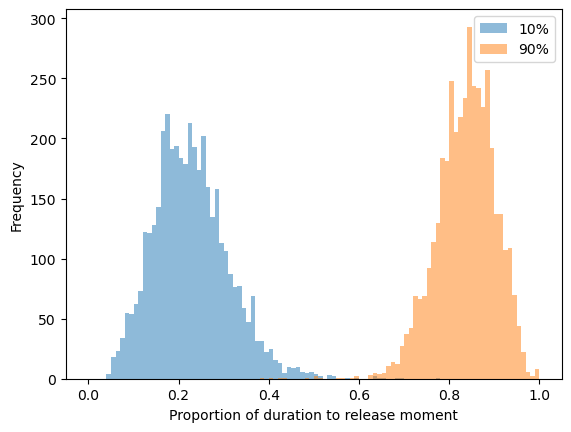

In [10]:
plt.hist(rel_root_times_10, bins = np.arange(0, 1.01, 0.01), alpha = 0.5, label='10%')
plt.hist(rel_root_times_90, bins = np.arange(0, 1.01, 0.01), alpha = 0.5, label='90%')
plt.ylabel('Frequency')
plt.xlabel('Proportion of duration to release moment')
plt.legend()
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_intervals_for_proportions_of_moment/comparison_histogram_fraction_of_duration_for_10_and_90_percent_moment.png')

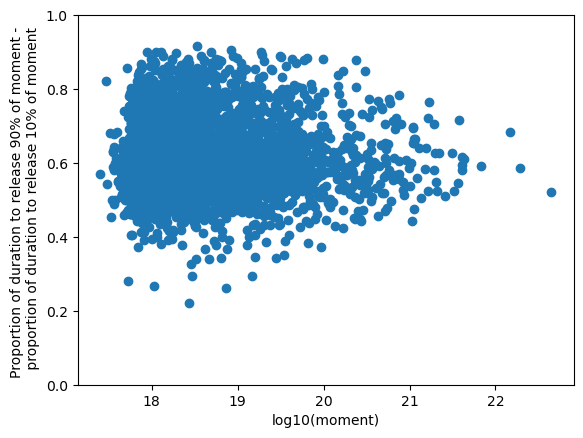

In [11]:
plt.scatter(moments, rel_root_times_90-rel_root_times_10)
plt.ylabel('Proportion of duration to release 90% of moment - \n proportion of duration to release 10% of moment')
plt.xlabel('log10(moment)')
plt.ylim(0, 1)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_intervals_for_proportions_of_moment/root_time_difference_10_90.png')

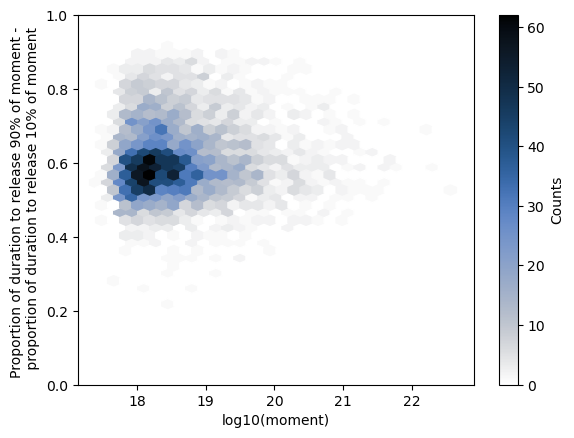

In [12]:
plt.hexbin(moments, rel_root_times_90-rel_root_times_10, gridsize=30, cmap=cmc.oslo_r)
plt.colorbar(label='Counts')
plt.ylabel('Proportion of duration to release 90% of moment - \n proportion of duration to release 10% of moment')
plt.xlabel('log10(moment)')
plt.ylim(0, 1)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_intervals_for_proportions_of_moment/root_time_difference_10_90_density_plot.png')

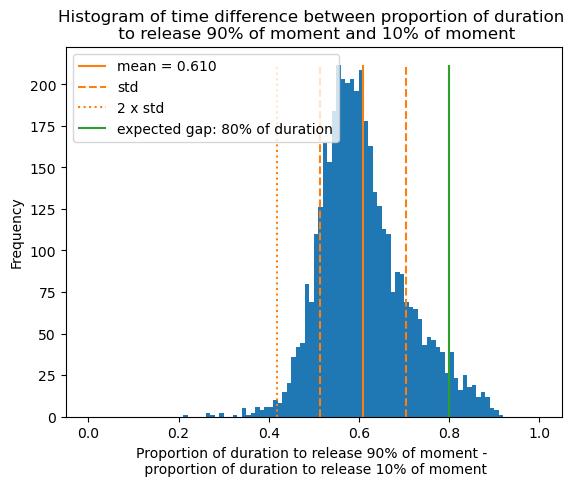

In [14]:
n, bins, patches = plt.hist(rel_root_times_90-rel_root_times_10, bins = np.arange(0, 1.01, 0.01))
mean_val = np.mean(rel_root_times_90-rel_root_times_10)
std = np.std(rel_root_times_90-rel_root_times_10)
plt.vlines(mean_val, 0, max(n), label = f'mean = {mean_val:.3f}', color = 'tab:orange')
plt.vlines(mean_val - std, 0, max(n), label = f'std', color = 'tab:orange', linestyles='dashed')
plt.vlines(mean_val + std, 0, max(n), color = 'tab:orange', linestyles='dashed')

plt.vlines(mean_val - 2*std, 0, max(n), label = f'2 x std', color = 'tab:orange', linestyles='dotted')
plt.vlines(mean_val + 2*std, 0, max(n), color = 'tab:orange', linestyles='dotted')

plt.vlines(0.8, 0, max(n), label = 'expected gap: 80% of duration', color = 'tab:green')
plt.legend()
plt.title('Histogram of time difference between proportion of duration \n to release 90% of moment and 10% of moment')
plt.ylabel('Frequency')
plt.xlabel('Proportion of duration to release 90% of moment - \n proportion of duration to release 10% of moment')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_intervals_for_proportions_of_moment/root_time_difference_10_90_histogram.png')